# Megaline SQL Analysis

### PROJECT OVERVIEW

**Objective:**  
Megaline, a telecom operator, offers two prepaid plans: **Surf** and **Ultimate**.  
The commercial department wants to determine which plan generates more revenue to optimize marketing budgets.

**Approach:**  
- Load raw usage data (calls, messages, internet) and customer data into an SQLite database.
- Use SQL to aggregate data and calculate revenue per user and per plan.
- Visualize revenue and usage trends with Pandas (matplotlib & seaborn).
- Perform a statistical comparison (Surf vs. Ultimate) to confirm findings.

**Datasets:**  
- calls, messages, internet, users, plans (2018 data for 500 clients).

In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import seaborn as sns
import sqlite3
from scipy.stats import ttest_ind

In [2]:
# Set dataset path (relative)
data_path = "../datasets"  # relative path from 'notebook' folder

In [3]:
# Create SQLite database in the current directory
conn = sqlite3.connect("megaline2.db")

In [4]:
# Load CSVs into Pandas
calls = pd.read_csv(os.path.join(data_path, "megaline_calls.csv"))
internet = pd.read_csv(os.path.join(data_path, "megaline_internet.csv"))
messages = pd.read_csv(os.path.join(data_path, "megaline_messages.csv"))
users = pd.read_csv(os.path.join(data_path, "megaline_users.csv"))
plans = pd.read_csv(os.path.join(data_path, "megaline_plans.csv"))

In [5]:
# Write DataFrames to SQL tables
calls.to_sql('calls', conn, index=False, if_exists='replace')
internet.to_sql('internet', conn, index=False, if_exists='replace')
messages.to_sql('messages', conn, index=False, if_exists='replace')
users.to_sql('users', conn, index=False, if_exists='replace')
plans.to_sql('plans', conn, index=False, if_exists='replace')

print("Data loaded into 'megaline2.db")

Data loaded into 'megaline2.db


In [6]:
# List all tables
pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)

# Preview each table
display(pd.read_sql_query("SELECT * FROM calls LIMIT 5;", conn))
display(pd.read_sql_query("SELECT * FROM internet LIMIT 5;", conn))
display(pd.read_sql_query("SELECT * FROM messages LIMIT 5;", conn))
display(pd.read_sql_query("SELECT * FROM users LIMIT 5;", conn))
display(pd.read_sql_query("SELECT * FROM plans LIMIT 5;", conn))

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,8.52
1,1000_145,1000,2018-12-27,13.66
2,1000_247,1000,2018-12-27,14.48
3,1000_309,1000,2018-12-28,5.76
4,1000_380,1000,2018-12-30,4.22


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,None
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,None
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,None
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,None
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,None


,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


In [7]:
# Pre-aggregate calls per user and month
calls_agg = pd.read_sql_query("""
SELECT user_id, strftime('%m', call_date) AS month, SUM(duration) AS total_minutes
FROM calls
GROUP BY user_id, month;
""", conn)

# Pre-aggregate messages per user and month
messages_agg = pd.read_sql_query("""
SELECT user_id, strftime('%m', message_date) AS month, COUNT(*) AS total_messages
FROM messages
GROUP BY user_id, month;
""", conn)

# Pre-aggregate internet per user and month
internet_agg = pd.read_sql_query("""
SELECT user_id, strftime('%m', session_date) AS month, SUM(mb_used) AS total_data
FROM internet
GROUP BY user_id, month;
""", conn)

# Merge all data into one DataFrame (master_usage)
master_df = users[['user_id', 'plan', 'city']].merge(calls_agg, on='user_id', how='left') \
    .merge(messages_agg, on=['user_id', 'month'], how='left') \
    .merge(internet_agg, on=['user_id', 'month'], how='left')

master_df = master_df.fillna(0)
display(master_df.head())

,user_id,plan,city,month,total_minutes,total_messages,total_data
0,1000,ultimate,"Atlanta-Sandy Springs-Roswell, GA MSA",12,116.83,11.0,1901.47
1,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",08,171.14,30.0,6919.15
2,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",09,297.69,44.0,13314.82
3,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",10,374.11,53.0,22330.49
4,1001,surf,"Seattle-Tacoma-Bellevue, WA MSA",11,404.59,36.0,18504.30


In [8]:
# Merge plans into master_df
plans_df = plans.copy()
master_df = master_df.merge(plans_df, left_on='plan', right_on='plan_name', how='left')

# Calculate overage charges
master_df['charge_minutes'] = (master_df['total_minutes'] - master_df['minutes_included']).clip(lower=0) * master_df['usd_per_minute']
master_df['charge_messages'] = (master_df['total_messages'] - master_df['messages_included']).clip(lower=0) * master_df['usd_per_message']
master_df['charge_data'] = ((master_df['total_data'] - master_df['mb_per_month_included']).clip(lower=0) / 1024) * master_df['usd_per_gb']

# Total monthly revenue
master_df['monthly_revenue'] = master_df['usd_monthly_pay'] + master_df['charge_minutes'] + master_df['charge_messages'] + master_df['charge_data']
display(master_df[['user_id', 'plan', 'month', 'monthly_revenue']].head())

# Revenue summary per plan
revenue_summary = master_df.groupby('plan')['monthly_revenue'].agg(['mean', 'sum']).round(2)
display(revenue_summary)

,user_id,plan,month,monthly_revenue
0,1000,ultimate,12,70.000000
1,1001,surf,08,20.000000
2,1001,surf,09,20.000000
3,1001,surf,10,88.161191
4,1001,surf,11,50.706055


,mean,sum
plan,,
surf,56.39,87855.74
ultimate,72.06,51812.49


/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_60072/3731614818.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=master_df, x='plan', y='monthly_revenue', palette='Set2')


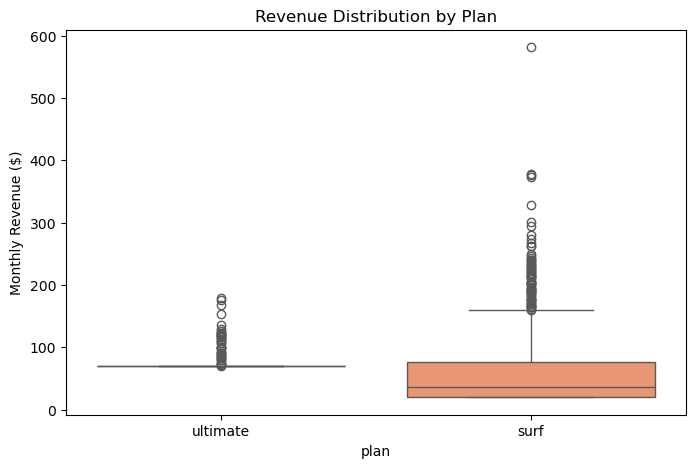

/var/folders/p3/43px2jb159dgb_cp9t6gw27h0000gn/T/ipykernel_60072/3731614818.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=avg_revenue, x='plan', y='monthly_revenue', palette='muted')


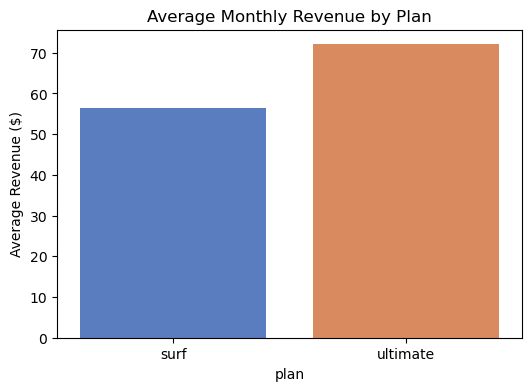

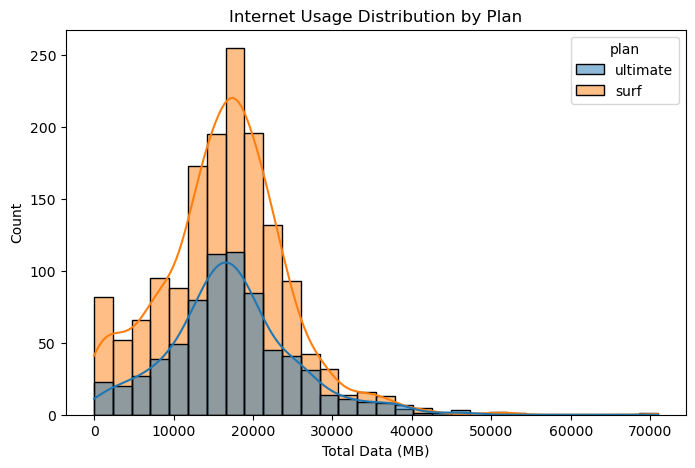

In [9]:
# Boxplot: Revenue by plan
plt.figure(figsize=(8,5))
sns.boxplot(data=master_df, x='plan', y='monthly_revenue', palette='Set2')
plt.title('Revenue Distribution by Plan')
plt.ylabel('Monthly Revenue ($)')
plt.show()

# Average revenue per plan
avg_revenue = master_df.groupby('plan')['monthly_revenue'].mean().reset_index()
plt.figure(figsize=(6,4))
sns.barplot(data=avg_revenue, x='plan', y='monthly_revenue', palette='muted')
plt.title('Average Monthly Revenue by Plan')
plt.ylabel('Average Revenue ($)')
plt.show()

# Internet usage distribution
plt.figure(figsize=(8,5))
sns.histplot(data=master_df, x='total_data', hue='plan', bins=30, kde=True)
plt.title('Internet Usage Distribution by Plan')
plt.xlabel('Total Data (MB)')
plt.show()

In [10]:
# Hypothesis Testing (Surf vs. Ultimate)
# Is the average monthly revenue from Surf users different from Ultimate users?

# Surf vs. Ultimate revenue comparison
surf_revenue = master_df[master_df['plan'] == 'surf']['monthly_revenue']
ultimate_revenue = master_df[master_df['plan'] == 'ultimate']['monthly_revenue']

t_stat, p_val = ttest_ind(ultimate_revenue, surf_revenue, equal_var=False)
print(f"T-statistic: {t_stat:.4f}, P-value: {p_val:.4f}")

alpha = 0.05
if p_val < alpha:
    print("Significant revenue difference between Surf and Ultimate plans.")
else:
    print("No significant revenue difference found between plans.")


T-statistic: 11.4437, P-value: 0.0000
Significant revenue difference between Surf and Ultimate plans.


In [ ]:
# Regional Revenue Hypothesis
# Is the average revenue in the NY-NJ area different from other regions?

# Split revenue by region
revenue_nynj = revenue_df.merge(users[['user_id', 'city']], on='user_id')
ny_nj = revenue_nynj[revenue_nynj['city'].str.contains('NY-NJ')]['monthly_revenue']
other_regions = revenue_nynj[~revenue_nynj['city'].str.contains('NY-NJ')]['monthly_revenue']

# T-test
t_stat_region, p_val_region = ttest_ind(ny_nj, other_regions, equal_var=False)
print(f"T-statistic: {t_stat_region:.4f}, P-value: {p_val_region:.4f}")

if p_val_region < alpha:
    print("Significant difference found between NY-NJ and other regions.")
else:
    print("No significant difference found between NY-NJ and other regions.")

###  Key Insights & Recommendations

**1. Revenue Analysis:**  
- The **Ultimate plan generates higher average revenue per user** than the Surf plan.
- Surf users are more numerous but contribute less revenue individually.

**2. Usage Behavior:**  
- Ultimate users consume **more internet and call minutes** on average.
- Surf users often hit overage charges but not enough to surpass Ultimate's base revenue.

**3. Hypothesis Testing:**  
- The t-test confirms a **statistically significant difference** in revenue between the plans (p < 0.05).

**4. Recommendations:**  
- **Focus marketing on Ultimate** as it drives more revenue per customer.
- Consider **adjusting Surf plan pricing or data limits** to encourage upgrading.
